# Profiling Dish LMC (Simulators)

## Introduction
This notebook aims to profile the Dish LMC, with the Simulator, in order to monitor CPU resources (Actual CPU usage, Limits% and Request%). The following resources are explained below.

## CPU Resources

### Actual CPU Usage

Actual CPU usage refers to the amount of CPU resources a process or container is consuming at a given time in relation to the total available CPU on the system or node. It is a real-time measurement of how much CPU power is being used by an application.

In the context of Kubernetes and containerized environments, actual CPU usage is related to CPU requests and CPU limits, and comparing these values helps determine whether an application is using resources efficiently or needs adjustments. Let’s break down how these concepts relate to one another.

### Limits

#### CPU Limits

- Definition: CPU limits represent the maximum number of CPU cores (or fractions of cores) that a container or pod is allowed to use in a Kubernetes environment.

- Unit: This is measured in CPU cores (e.g., 1.0 means 1 full CPU core, 0.5 means half a core).

- Usage: When you set CPU limits for a pod, you are capping its CPU usage. The pod will not be able to use more CPU than the defined limit, even if the node has additional CPU resources available.

#### CPU Limits%
##### (The one we look at in through this Notebook)

- Definition: CPU limits% refers to the percentage of the total available CPU capacity that a pod's CPU limit represents.

- Unit: This is measured as a percentage. For example, if the node has 4 CPU cores and the pod's CPU limit is set to 2 cores, the CPU limits% would be 50%.

- Usage: This metric gives you an idea of what portion of the node's total CPU capacity is reserved as the maximum for that pod or container.

### Requests

#### CPU Requests

- Definition: CPU requests represent the absolute number of CPU cores (or fractions of cores) that a container or pod is guaranteed to have in a Kubernetes environment.

- Unit: This is typically measured in CPU cores. For example, 1.0 means one full CPU core, while 0.5 means half a core.

- Usage: When you set CPU requests for a pod, you are telling Kubernetes to guarantee that amount of CPU for the pod. The pod will always get at least this much CPU, ensuring it has enough processing power.

#### CPU Requests%

- Definition: CPU requests% refers to the percentage of the CPU capacity being requested relative to the total available CPU in the node or environment.

- Unit: This is measured as a percentage. For example, if the node has 4 CPU cores and a pod requests 2 cores, the CPU requests% would be 50%.

- Usage: This metric is used to understand what portion of the available CPU capacity a pod or set of pods is requesting. It gives you an idea of how much of the node's total resources are being reserved.

## Data Analysis

### Sufficient CPU Resources
##### (What we ideally would want to be the case)

- Actual CPU usage consistently stays below Requests% and far below Limits%.
- If Actual CPU % is significantly below Requests% and Limits%, your CPU requests and limits are sufficient.

### Insufficient CPU Resources
- If Actual CPU% is close to or exceeds Requests%, it indicates that the CPU requests might be too low for your workload.
- If Actual CPU% frequently approaches or exceeds Limits%, your container might be throttled, suggesting that the CPU limits are too restrictive.

### Idle CPU usage
This is what is seen when the deployment is idle - according to the information stated above the CPUs resources are sufficient in its idle state.
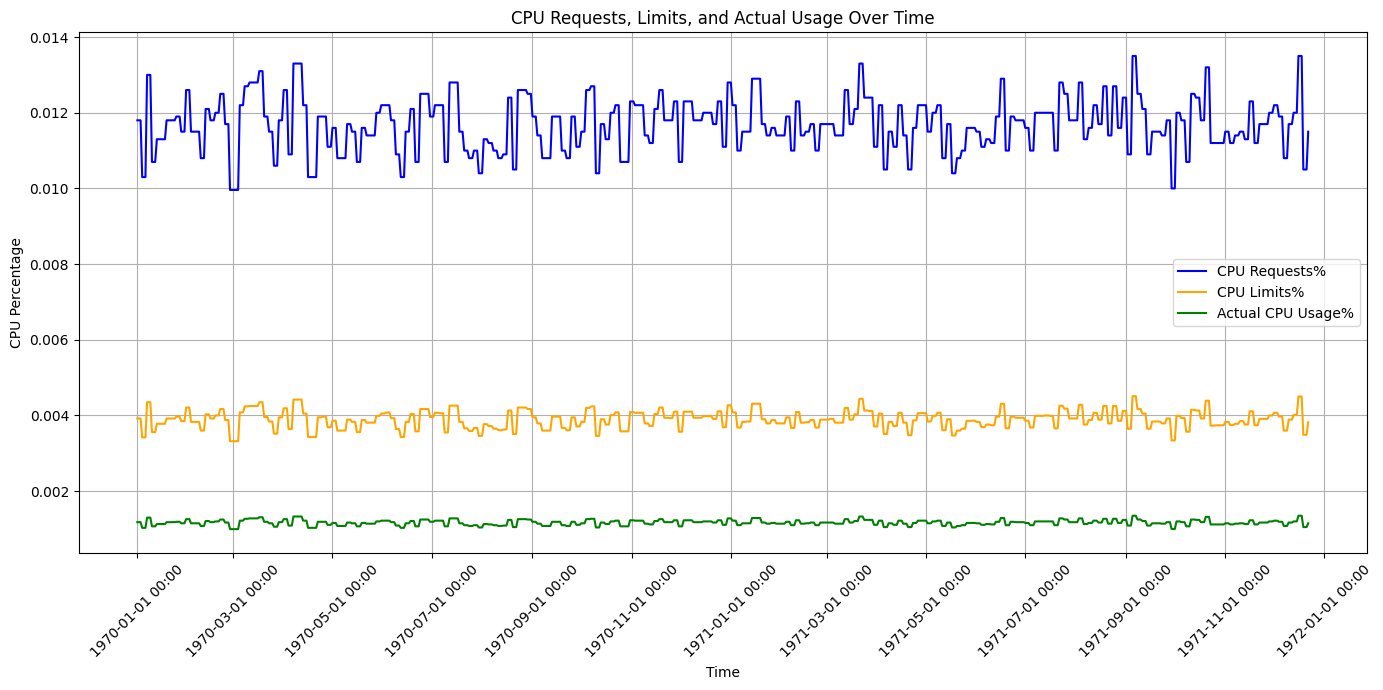

## Command and Analysis

### Command

`Track()` is used to profile the deployments, within the ITF, the data can be read from the radial.csv, found in this directory, you can upload them into your server. Note, you may have to limit the the number of track tables or the speed in which you call `Track()` because your Jupyter Notebook may crash. Fot demonostration purposes this Notebook submits 2000 track tables of size 10, `[time_n0,az_n0,el_n0,time_1,az_1,el_1,...time_9,az_9,el_9]` in 5s intervals. Feel free to tweak it to suit your needs.

### Grafana

View the effect of Track command on Grafana. For Simulators, make sure the following are selected:

- Cluster: mid-itf-monitor
- Namespace: miditf-lmc-003-karoo-sims
- Pod: ds-dishmanager-003-0

## Supporting Files

- setup_env.py
- sprial.csv (Pointing params)
- radial.csv (Pointing params)

## Results (KAR-1143)
If you'd like to see the results captured from this Notebook, see **KAR-1143**. The graph below, taken on 2 October 2024, shows that the CPU usage was sufficient as explained above (2000 Track Tables). At all times, duirng the deployments idle state and during `Track()` execution, the **Actual CPU% < Limits% < Request%**

The subscriptions also steadily updated as the data was being fed to the deployment in the ITF. No notable issues were observed.




----------------------------------------------------

# Notebook Execution

#### Install dependencies:

In [ ]:
!pip3 install pytango
!pip3 install ska_mid_dish_manager --extra-index=https://artefact.skao.int/repository/pypi-internal/simple
!pip3 install kubernetes matplotlib
!pip3 install pandas
!pip3 install matplotlib

#### Getting connected to the Dish LMC (Simulator) deployment:

In [ ]:
import csv
import threading
import time

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import tango
from kubernetes import client, config
from setup_env import init_env
from ska_mid_dish_manager.models.dish_enums import PointingState, TrackTableLoadMode

device_proxies = init_env(namespace="miditf-lmc-002-ds", dish_id="SKA002")
print(f"\nDevice proxy keys in device_proxy:\n{device_proxies.keys()}")

#### Dish Structure Manager version:

In [ ]:
dsm_proxy = device_proxies["ds_manager_proxy"]
print(f"{dsm_proxy.buildState}")

#### SPFRx version:

In [ ]:
spfrx_proxy = device_proxies["spfrx_proxy"]
print(f"{spfrx_proxy.swVersions}")

#### SPFC version:

In [ ]:
spfc_proxy = device_proxies["spfc_proxy"]
print(f"{spfc_proxy.swVersions}")

#### Dish Manager version:

In [ ]:
dm_proxy = device_proxies["dish_manager_proxy"]
print(f"{dm_proxy.buildState}")

#### Dish LMC version:

In [ ]:
dl_proxy = device_proxies["dish_logger_proxy"]
print(f"{dl_proxy.buildState}")

#### Check Modes:

In [ ]:
# Check the deployment
print("Dish Mode:\t", dm_proxy.dishMode.name)
print("DS Manager:\t", dsm_proxy.operatingMode.name)
print("SPFRx:\t", spfrx_proxy.operatingMode.name)
print("SPFC:\t", spfc_proxy.operatingMode.name)

#### Set Up Subscriptions to print output as values change:

In [ ]:
# Clear 10 subscriptions. Just to prevent duplicate messages when rerunning the cell
for i in range(10):
    try:
        dm_proxy.unsubscribe_event(i)
    except KeyError:
        pass
    try:
        dsm_proxy.unsubscribe_event(i)
    except KeyError:
        pass


# Get current time in seconds (float) with millisecond precision
def get_time():
    current_time_seconds = time.time()
    # Convert to milliseconds
    current_time_milliseconds = int(current_time_seconds * 1000)
    return current_time_milliseconds


def print_az_el(ev):
    if ev.attr_value:
        print(
            (
                f"{get_time()}: DishManager achievedPointing: Time: {ev.attr_value.value[0]} AZ: "
                f"{ev.attr_value.value[1]} EL: {ev.attr_value.value[2]}"
            )
        )


def print_pointing_state(ev):
    if ev.attr_value:
        print(f"{get_time()}: DishManager PointingState {PointingState(ev.attr_value.value).name}")


def print_dm_event(ev):
    if ev.attr_value:
        print(f"{get_time()}: DishManager {ev.attr_value.name} {ev.attr_value.value}")


def print_dsm_event(ev):
    if ev.attr_value:
        print(f"DishStructureManager {ev.attr_value.name} {ev.attr_value.value}")


_ = dm_proxy.subscribe_event(
    "achievedPointing",
    tango.EventType.CHANGE_EVENT,
    print_az_el,
)

_ = dm_proxy.subscribe_event(
    "longrunningcommandprogress",
    tango.EventType.CHANGE_EVENT,
    print_dm_event,
)

_ = dm_proxy.subscribe_event(
    "longrunningcommandstatus",
    tango.EventType.CHANGE_EVENT,
    print_dm_event,
)

_ = dm_proxy.subscribe_event(
    "longRunningCommandResult",
    tango.EventType.CHANGE_EVENT,
    print_dm_event,
)

_ = dm_proxy.subscribe_event(
    "pointingState",
    tango.EventType.CHANGE_EVENT,
    print_pointing_state,
)


_ = dsm_proxy.subscribe_event(
    "longrunningcommandprogress",
    tango.EventType.CHANGE_EVENT,
    print_dsm_event,
)

_ = dsm_proxy.subscribe_event(
    "longrunningcommandstatus",
    tango.EventType.CHANGE_EVENT,
    print_dsm_event,
)

_ = dsm_proxy.subscribe_event(
    "longrunningcommandresult",
    tango.EventType.CHANGE_EVENT,
    print_dsm_event,
)

#### Transition to Full Power:

In [ ]:
if dm_proxy.dishMode.name == "STANDBY_LP":
    dm_proxy.SetStandbyFPMode()

#### Configure band 2:

In [ ]:
dm_proxy.ConfigureBand2(True)

#### Transition to Operate mode:

In [ ]:
if dm_proxy.dishMode.name == "STANDBY_FP":
    dm_proxy.SetOperateMode()

#### Start Monitoring the CPU usage thread (Limits and Requests):

Note: This section was put in but has not been tested due to access rights to the kube config file. It however aims to pull the limits and requests from Kubernetes, to negate the need to download data from grafana in order to plot the analysis graphs. You do not have run this section. Instead you can view the effects of the Track() command being run on Grafana as explained in the **Introduction**

In [ ]:
# Load Kubernetes configuration
config.load_kube_config()
v1 = client.CoreV1Api()


def get_pod_resources(namespace, pod_name):
    """Fetch CPU Requests and Limits for a specific pod."""
    pod = v1.read_namespaced_pod(name=pod_name, namespace=namespace)
    containers = pod.spec.containers

    for container in containers:
        cpu_requests = container.resources.requests.get("cpu", "Not set")
        cpu_limits = container.resources.limits.get("cpu", "Not set")
        print(
            f"Container: {container.name} | CPU Requests: {cpu_requests}"
            f" | CPU Limits: {cpu_limits}"
        )


def get_pod_cpu_usage(namespace, pod_name):
    """Fetch CPU usage for a specific pod from metrics.k8s.io API."""
    metrics = client.CustomObjectsApi()
    pod_metrics = metrics.list_namespaced_custom_object(
        group="metrics.k8s.io",
        version="v1beta1",
        namespace=namespace,
        plural="pods",
        field_selector=f"metadata.name={pod_name}",
    )

    cpu_usage = pod_metrics["items"][0]["containers"][0]["usage"]["cpu"]
    return cpu_usage


def monitor_cpu_usage(namespace, pod_name, duration=300, interval=5):
    """Monitor CPU usage over time."""
    usage_data = []
    time_data = []

    start_time = time.time()

    while time.time() - start_time < duration:
        current_usage = get_pod_cpu_usage(namespace, pod_name)
        usage_data.append(
            float(current_usage.replace("n", "")) / 1e9
        )  # Convert nanocores to cores
        time_data.append(time.time() - start_time)

        print(f"CPU Usage at {time_data[-1]}s: {usage_data[-1]} cores")

        time.sleep(interval)  # Wait before next poll

    # Plot CPU usage over time
    plt.plot(time_data, usage_data, label="CPU Usage")
    plt.xlabel("Time (s)")
    plt.ylabel("CPU Usage (cores)")
    plt.title(f"CPU Usage for Pod {pod_name} over {duration // 60} minutes")
    plt.legend()
    plt.show()


# Example: Run the monitor for 5 minutes (300 seconds) with 5-second intervals
namespace = "miditf-lmc-002-ds"
pod_name = "ds-dishmanager-002-0"

monitor_thread = threading.Thread(target=monitor_cpu_usage, args=(namespace, pod_name, 300, 5))
monitor_thread.start()

In [ ]:
# Read the tracking csv files:

In [ ]:
def read_table_entries_from_csv(file_path):
    """
    Read table entries (time, azimuth, elevation) from a CSV file.
    """
    table_entries = []
    with open(file_path, mode="r") as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header
        for row in csv_reader:
            time_from_start = float(row[0])
            azimuth = float(row[1])
            elevation = float(row[2])
            table_entries.append((time_from_start, azimuth, elevation))
    return table_entries

#### Read the tracking data from the radial file:

Note: If you have uploaded the the .csv's below then then you can execute this section. If you chosen to used your own please modify this section before executing.

In [ ]:
radial_entries = read_table_entries_from_csv("radial.csv")

#### Get Current TAI: 

In [ ]:
# Get TAI offset of current time with SKA epoch


def get_current_tai_timestamp():
    return time.time() - 946684763.0

#### Create track table  and initialize track table method:

In [ ]:
# Function to program track tables and call Track()


def create_and_track_program_track_tables(data_entries):
    table_entries = data_entries
    chunk_size = 10  # Process entries in chunks of 10
    current_time_tai_s = None  # Initial TAI timestamp
    first_chunk = True  # Flag to check if this is the first table
    stop = 0
    for i in range(0, len(table_entries), chunk_size):
        # Create a new or append track table based on whether it's the first chunk
        if first_chunk:
            mode = TrackTableLoadMode.NEW
            current_time_tai_s = get_current_tai_timestamp()
            first_chunk = False
        else:
            mode = TrackTableLoadMode.APPEND
            current_time_tai_s = get_current_tai_timestamp() + 5

        # Get the next chunk of table entries
        chunk = table_entries[i : i + chunk_size]  # noqa
        track_table = []

        # Add the number of entries in this chunk
        dm_proxy.trackTableLoadMode = mode
        # Add each table entry to the track table
        for time_from_start, az, el in chunk:
            adjusted_time = current_time_tai_s + time_from_start
            track_table.append(adjusted_time)  # Adjusted time
            track_table.append(az)  # Azimuth
            track_table.append(el)  # Elevation

        # Program the track table
        dm_proxy.programTrackTable = track_table

        # Check the pointing state and call Track() if ready

        if stop == 500:
            # Call Trackstop
            dm_proxy.TrackStop()
            print("STOPPED")
            break  # forcefully breaks the tracking
        else:
            dm_proxy.Track()
            stop = stop + 1

#### Start Tracking:

Note: The entries from the radial.csv are used here. Modify as need be.

In [ ]:
def track_and_monitor():

    # We assume dm_proxy is alive and its PointingState is available
    # This line should be kept active if you chose to extract data through
    # Kubernetes rather than view it on Grafana
    if dm_proxy.pointingstate == PointingState.READY:
        # while monitor_thread.is_alive():  # Run as long as the monitor is active
        for data_entries in [radial_entries]:
            # Create and process track table in batches of 10
            create_and_track_program_track_tables(data_entries)
    else:
        print("Waiting for PointingState to be READY...")
        time.sleep(5)  # Random wait time


track_and_monitor()

#### Plotting:

In order to plot download the 3 .csv files from Grafana and upload them to Jupyter Notebooks. The three files you need are from the CPU Quota widget. Follow these steps

- Click the three vertical dots in the right hand side of the widget
- Click on **Inspect**
- Click on **Data options**
- From the dropdown menu click download the following files
    - container, Value #A (0) <- This represents the CPU %
    - container, Value #C (2) <- This represents the Requests %
    - container, Value #E (4) <- This represents the Limits %

Note: Make sure that have selected the correct time period ie: Last 15 minutes....

- Now modify the file below to plot the "CPU Requests, Limits, and Actual Usage Over Time" graph.


In [ ]:
# Load data from CSV files
requests_df = pd.read_csv("requests.csv")  # CSV for CPU Requests MODIFY!!!
limits_df = pd.read_csv("limits.csv")  # CSV for CPU Limits MODIFY!!!
usage_df = pd.read_csv("cpu.csv")  # CSV for Actual CPU Usage MODIFY!!!

# Assuming the CSVs have columns: time, container_name, value
# We only need 'time' and 'value', so we'll drop 'container_name'
requests_df = requests_df[["Time", "Value #C"]]
limits_df = limits_df[["Time", "Value #E"]]
usage_df = usage_df[["Time", "Value #A"]]

# Rename columns for clarity
requests_df.rename(columns={"Value #C": "CPU Requests%"}, inplace=True)
limits_df.rename(columns={"Value #E": "CPU Limits%"}, inplace=True)
usage_df.rename(columns={"Value #A": "Actual CPU Usage%"}, inplace=True)

# Merge data on 'time'
merged_df = pd.merge(requests_df, limits_df, on="Time", how="outer")
merged_df = pd.merge(merged_df, usage_df, on="Time", how="outer")

# Set 'time' as the index
merged_df.set_index("Time", inplace=True)

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(merged_df.index, merged_df["CPU Requests%"], label="CPU Requests%", color="blue")
plt.plot(merged_df.index, merged_df["CPU Limits%"], label="CPU Limits%", color="orange")
plt.plot(merged_df.index, merged_df["Actual CPU Usage%"], label="Actual CPU Usage%", color="green")

# Customize the plot
plt.title("CPU Requests, Limits, and Actual Usage Over Time")
plt.xlabel("Time")
plt.ylabel("CPU Percentage")
plt.legend()

# Set date formatting for the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.gca().xaxis.set_major_locator(
    mdates.AutoDateLocator(minticks=10, maxticks=15)
)  # Reduce number of ticks

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()